In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm
from itertools import product

In [2]:
hamiltonian_0 = np.block([
    [0 * np.eye(2), np.eye(2)],
    [np.eye(2), 0 * np.eye(2)]
])
hamiltonian_0 = np.expand_dims(hamiltonian_0, axis=0)
hopping_vecs = np.array([[0,]])

In [3]:
hamiltonian_0.shape

(1, 4, 4)

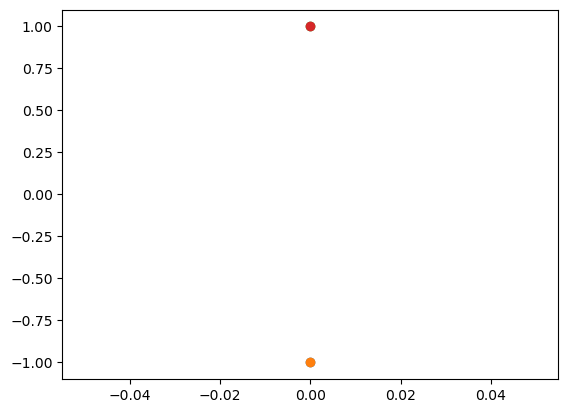

In [4]:
vals, vecs = np.linalg.eigh(hamiltonian_0)
plt.plot(vals, 'o')
plt.show()

In [57]:
def compute_vals(
    H_int,
    hamiltonian_0=hamiltonian_0,
    filling=2,
    tol=1e-5,
    mixing=0.01,
    order=10,
    guess=None
):
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess([0], hopping_vecs, ndof=hamiltonian_0.shape[-1], scale=1)
    else:
        guess += np.max(guess) * utils.generate_guess([0], hopping_vecs, ndof=hamiltonian_0.shape[-1], scale=0.1)

    # Find groundstate Hamiltonian on the same grid
    h = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonian_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(h)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    return vals - E_F

In [79]:
def compute_phase_diagram(
    Us,
    Vs,
    tol=1e-5,
    mixing=0.1,
    order=5,
):
    # onsite interactions
    onsite_int = np.block(
        [[np.ones((2, 2)), np.zeros((2, 2))], [np.zeros((2, 2)), np.ones((2, 2))]]
    )
    onsite_int = np.expand_dims(onsite_int, axis=0)
    # Nearest-neighbor interactions
    nn_int = np.block(
        [[np.zeros((2, 2)), np.ones((2, 2))], [np.zeros((2, 2)), np.zeros((2, 2))]]
    )
    nn_int = np.expand_dims(nn_int, axis=0)
    vals = []
    for U in tqdm(Us):
        gap_U = []
        vals_U = []
        for V in Vs:
            H_int = U * onsite_int + V * nn_int
            _vals = compute_vals(
                H_int=H_int,
                tol=tol,
                mixing=mixing,
                order=order,
            )
            vals_U.append(_vals)
        vals.append(vals_U)
    return np.asarray(vals)

In [81]:
# Interaction strengths
Us = np.linspace(0, 5, 20, endpoint=True)
Vs = np.linspace(0, 1, 20, endpoint=True)
vals = compute_phase_diagram(Us, Vs, tol=1e-5)

100%|██████████| 20/20 [01:02<00:00,  3.15s/it]


In [82]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(
        vals=(["Us", "Vs", "n"], vals[:,:,0,:]),
    ),
    coords=dict(Us=Us, Vs=Vs, n=np.arange(vals.shape[-1])),
)

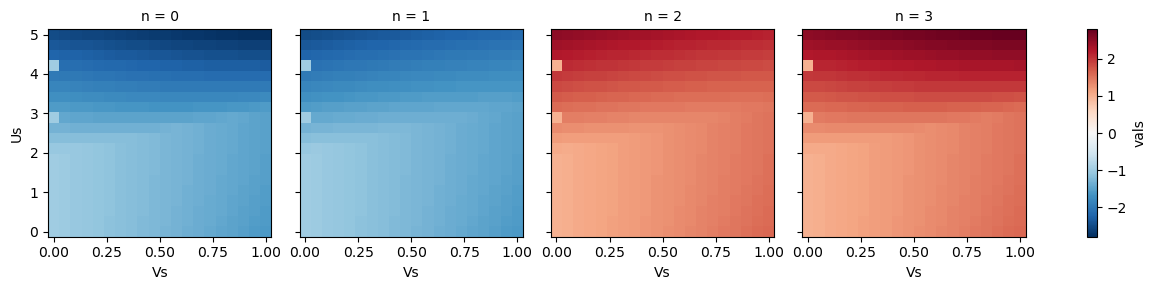

In [83]:
ds.vals.plot(col='n')
plt.show()

In [37]:
ds.to_netcdf('./data/diatomic_molecule_example.nc')